<a href="https://colab.research.google.com/github/Shaitender/kaggle_notebooks/blob/master/StyleGAN2_Google_Colab_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# StyleGAN2

This notebook demonstrates how to run NVIDIA's StyleGAN2 on Google Colab.
Make sure to specify a GPU runtime.

This notebook mainly adds a few convenience functions. 

For information on StyleGAN2, see:

Paper: https://arxiv.org/abs/1812.04948

Video: https://youtu.be/kSLJriaOumA

Code: https://github.com/NVlabs/stylegan

FFHQ: https://github.com/NVlabs/ffhq-dataset


In [0]:
%tensorflow_version 1.x
import tensorflow as tf

# Download the code
!git clone https://github.com/NVlabs/stylegan2.git
%cd stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run

print('Tensorflow version: {}'.format(tf.__version__) )
!nvidia-smi -L
print('GPU Identified at: {}'.format(tf.test.gpu_device_name()))

Cloning into 'stylegan2'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 88 (delta 5), reused 7 (delta 2), pack-reused 73
Unpacking objects: 100% (88/88), done.
/content/stylegan2
CPU says hello.
GPU says hello.
Tensorflow version: 1.15.0
GPU 0: Tesla P4 (UUID: GPU-48bb682f-c6b0-58c1-e879-5415aa0c3259)
GPU Identified at: /device:GPU:0


In [0]:
# Download the model of choice
import argparse
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio

import pretrained_networks

# Choose between these pretrained models - I think 'f' is the best choice:

# 1024×1024 faces
# stylegan2-ffhq-config-a.pkl
# stylegan2-ffhq-config-b.pkl
# stylegan2-ffhq-config-c.pkl
# stylegan2-ffhq-config-d.pkl
# stylegan2-ffhq-config-e.pkl
# stylegan2-ffhq-config-f.pkl

# 512×384 cars
# stylegan2-car-config-a.pkl
# stylegan2-car-config-b.pkl
# stylegan2-car-config-c.pkl
# stylegan2-car-config-d.pkl
# stylegan2-car-config-e.pkl
# stylegan2-car-config-f.pkl

# 256x256 horses
# stylegan2-horse-config-a.pkl
# stylegan2-horse-config-f.pkl

# 256x256 churches
# stylegan2-church-config-a.pkl
# stylegan2-church-config-f.pkl

# 256x256 cats
# stylegan2-cat-config-f.pkl
# stylegan2-cat-config-a.pkl
network_pkl = "gdrive:networks/stylegan2-ffhq-config-f.pkl"

# If downloads fails, due to 'Google Drive download quota exceeded' you can try downloading manually from your own Google Drive account
# network_pkl = "/content/drive/My Drive/GAN/stylegan2-ffhq-config-f.pkl"

print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

/content/stylegan2


Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


In [0]:
# Useful utility functions...

# Generates a list of images, based on a list of latent vectors (Z), and a list (or a single constant) of truncation_psi's.


def generate_images_in_w_space(dlatents, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    Gs_kwargs.truncation_psi = truncation_psi
    dlatent_avg = Gs.get_var('dlatent_avg') # [component]

    imgs = []
    for row, dlatent in log_progress(enumerate(dlatents), name = "Generating images"):
        #row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * np.reshape(truncation_psi, [-1, 1, 1]) + dlatent_avg
        dl = (dlatent-dlatent_avg)*truncation_psi   + dlatent_avg
        row_images = Gs.components.synthesis.run(dlatent,  **Gs_kwargs)
        imgs.append(PIL.Image.fromarray(row_images[0], 'RGB'))
    return imgs       

def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in log_progress(enumerate(zs), size = len(zs), name = "Generating images"):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
    return imgs

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
        
    return zs

# Generates a list of images, based on a list of seed for latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

def saveImgs(imgs, location):
  for idx, img in log_progress(enumerate(imgs), size = len(imgs), name="Saving images"):
    file = location+ str(idx) + ".png"
    img.save(file)

def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  str_file = BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

        
def clamp(x, minimum, maximum):
    return max(minimum, min(x, maximum))
    
def drawLatent(image,latents,x,y,x2,y2, color=(255,0,0,100)):
  buffer = PIL.Image.new('RGBA', image.size, (0,0,0,0))
   
  draw = ImageDraw.Draw(buffer)
  cy = (y+y2)/2
  draw.rectangle([x,y,x2,y2],fill=(255,255,255,180), outline=(0,0,0,180))
  for i in range(len(latents)):
    mx = x + (x2-x)*(float(i)/len(latents))
    h = (y2-y)*latents[i]*0.1
    h = clamp(h,cy-y2,y2-cy)
    draw.line((mx,cy,mx,cy+h),fill=color)
  return PIL.Image.alpha_composite(image,buffer)
             
  
def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas

def convertZtoW(latent, truncation_psi=0.7, truncation_cutoff=9):
  dlatent = Gs.components.mapping.run(latent, None) # [seed, layer, component]
  dlatent_avg = Gs.get_var('dlatent_avg') # [component]
  for i in range(truncation_cutoff):
    dlatent[0][i] = (dlatent[0][i]-dlatent_avg)*truncation_psi + dlatent_avg
    
  return dlatent

def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

# Taken from https://github.com/alexanderkuk/log-progress
def log_progress(sequence, every=1, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )





In [0]:
# from google.colab import drive
# drive.mount('/content/drive')


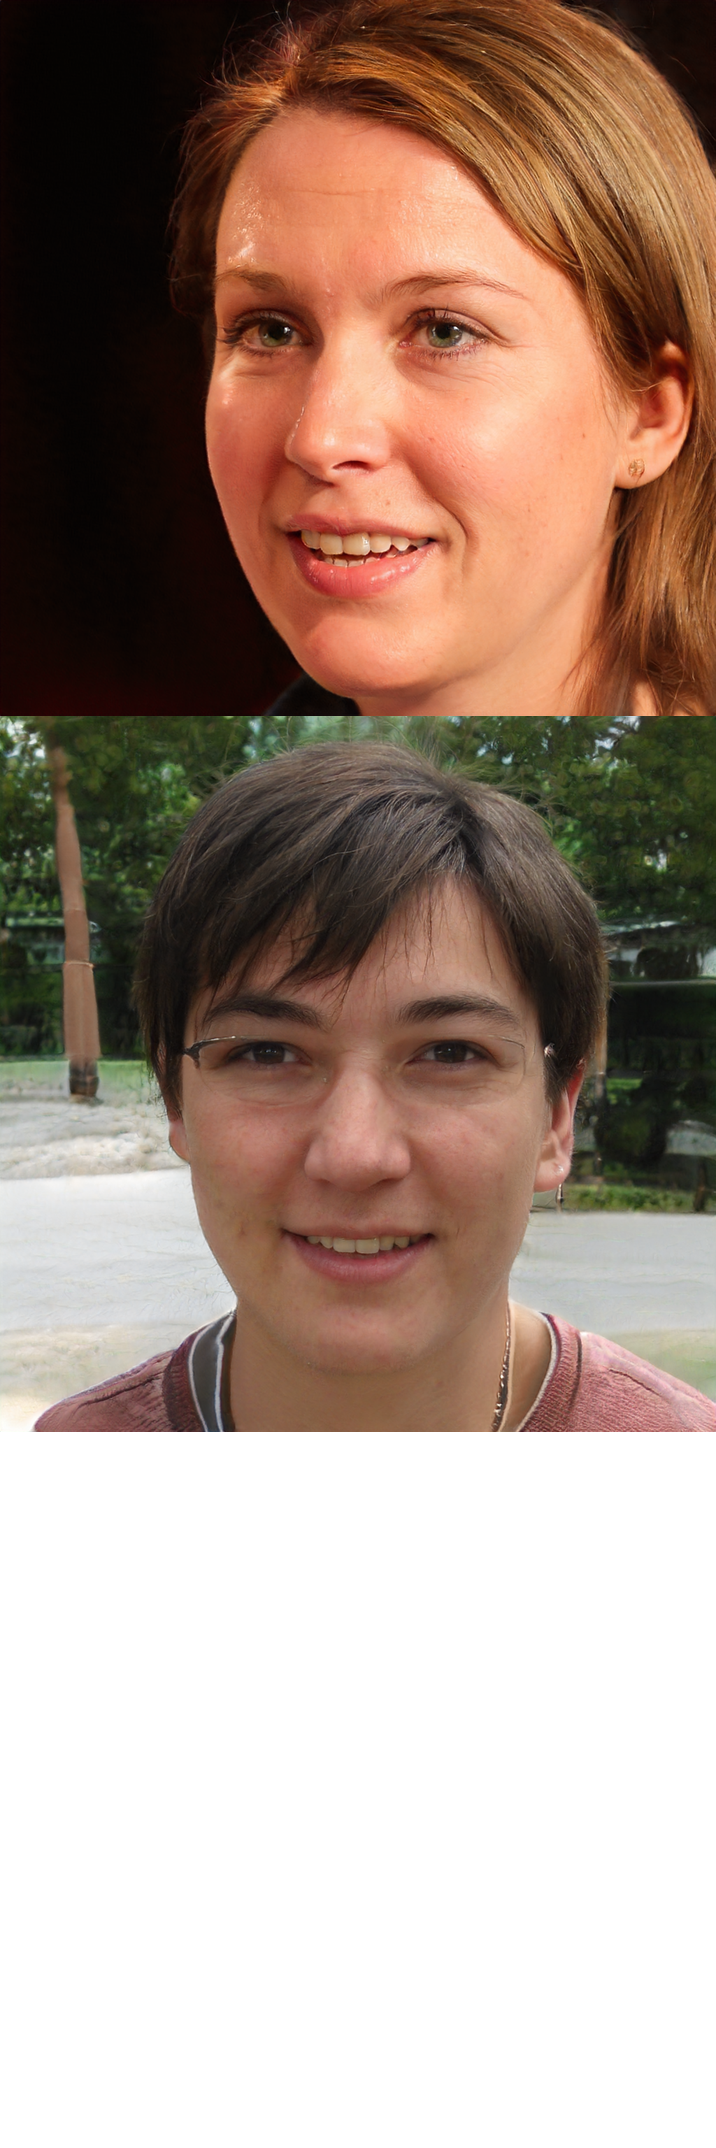

In [0]:
# generate some random seeds
seeds = np.random.randint(10000000, size=2)
#print(seeds)

# show the seeds
imshow(createImageGrid(generate_images_from_seeds(seeds, 0.7), 0.7 , 3))

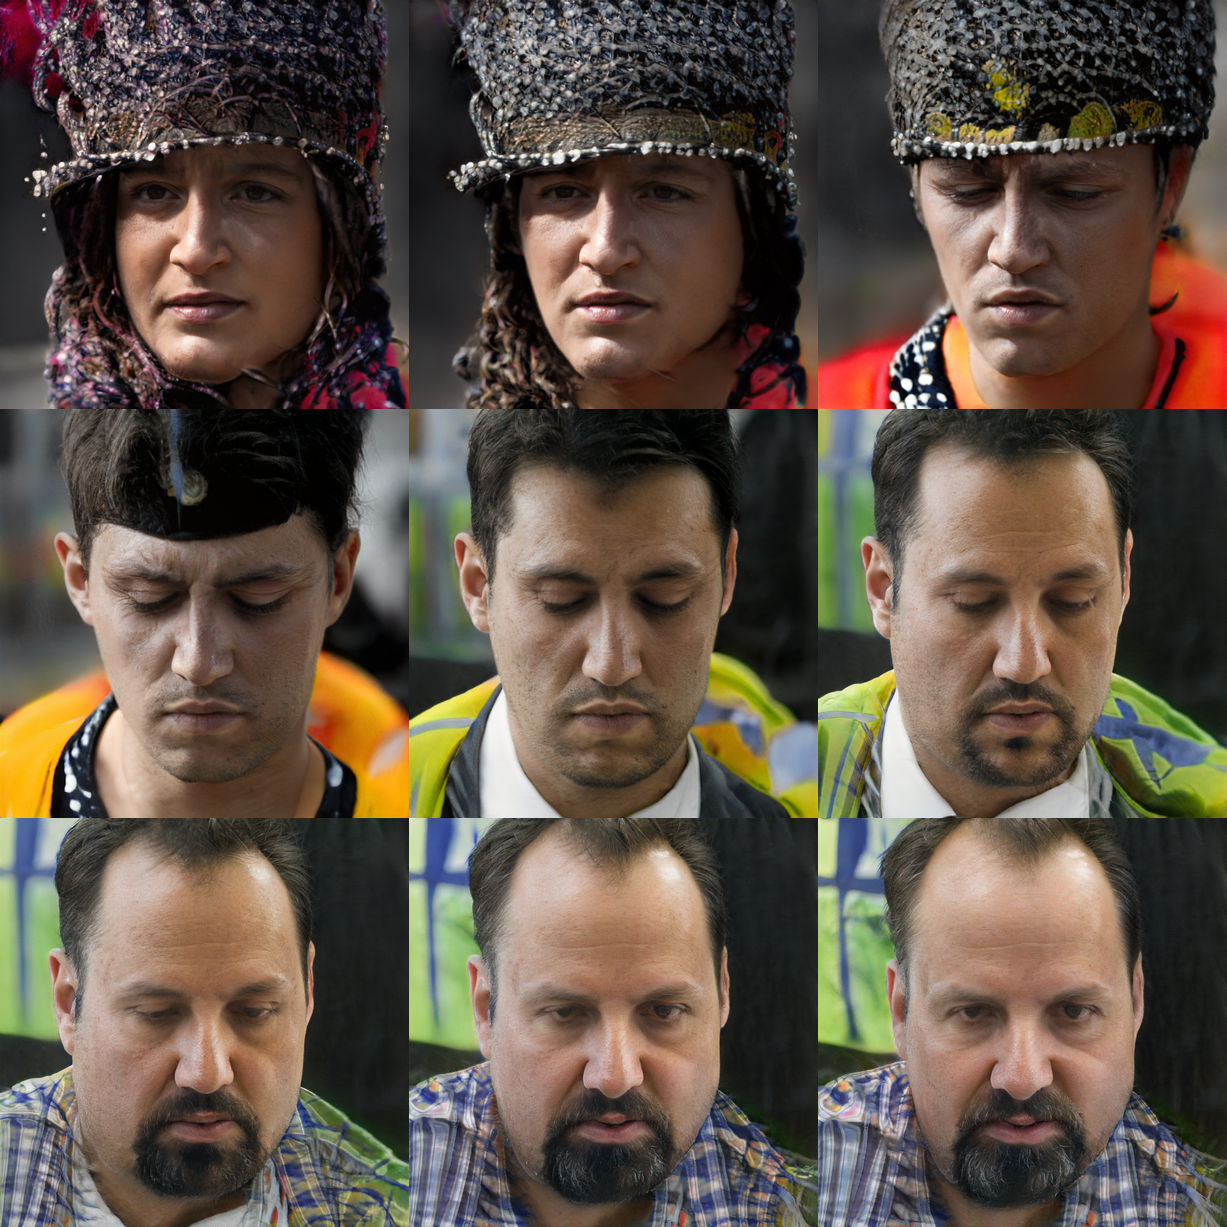

In [0]:
# Simple (Z) interpolation
zs = generate_zs_from_seeds([5015289 , 9148088 ])

latent1 = zs[0]
latent2 = zs[1]

number_of_steps = 9

imgs = generate_images(interpolate([latent1,latent2],number_of_steps), 1.0)
number_of_images = len(imgs)
imshow(createImageGrid(imgs, 0.4 , 3))

In [0]:
# generating a MP4 movie

zs = generate_zs_from_seeds([421645])

number_of_steps = 10
imgs = generate_images(interpolate(zs,number_of_steps), 1.0)

# Example of reading a generated set of images, and storing as MP4.
%mkdir out
movieName = 'out/mov.mp4'

with imageio.get_writer(movieName, mode='I') as writer:
    for image in log_progress(list(imgs), name = "Creating animation"):
        writer.append_data(np.array(image))

mkdir: cannot create directory ‘out’: File exists


In [0]:
# In order to download files, you can use the snippet below - this often fails for me, though, so I prefer the 'Files' browser in the sidepanel.

from google.colab import files
files.download(movieName) 


In [0]:
# If you want to store files to your Google drive, run this cell...

from google.colab import drive
drive.mount('/content/gdrive')

import os
import time
print( os.getcwd() )
location = "/content/gdrive/My Drive/PythonTests"
print( os.listdir(location) )

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/stylegan2
['gt10.k4.gz', 'labels.txt', 'k4data.gz', 'k4labels.txt', 'k4data', 'gt10.k4', 'line.html', 'sequence.fasta', 'ref.fa', 'StyleGan']


In [0]:
# more complex example, interpolating in W instead of Z space.
zs = generate_zs_from_seeds([421645,6149575 ])

# It seems my truncation_psi is slightly less efficient in W space - I probably introduced an error somewhere...

dls = []
for z in zs:
  dls.append(convertZtoW(z ,truncation_psi=1.0))

number_of_steps = 100

imgs = generate_images_in_w_space(interpolate(dls,number_of_steps), 1.0)

%mkdir out
movieName = 'out/mov.mp4'

with imageio.get_writer(movieName, mode='I') as writer:
    for image in log_progress(list(imgs), name = "Creating animation"):
        writer.append_data(np.array(image))

mkdir: cannot create directory ‘out’: File exists


# Projecting images onto the generatable manifold

StyleGAN2 comes with a projector that finds the closest generatable image based on any input image. This allows you to get a feeling for the diversity of the portrait manifold.

In [0]:
!mkdir projection
!mkdir projection/imgs
!mkdir projection/out

# Now upload a single image to 'stylegan2/projection/imgs' (use the Files side panel). Image should be color PNG, with a size of 1024x1024.

In [0]:
# Convert uploaded images to TFRecords
import dataset_tool
dataset_tool.create_from_images("./projection/records/", "./projection/imgs/", True)

# Run the projector
import run_projector
import projector
import training.dataset
import training.misc
import os 

def project_real_images(dataset_name, data_dir, num_images, num_snapshots):
    proj = projector.Projector()
    proj.set_network(Gs)

    print('Loading images from "%s"...' % dataset_name)
    dataset_obj = training.dataset.load_dataset(data_dir=data_dir, tfrecord_dir=dataset_name, max_label_size=0, verbose=True, repeat=False, shuffle_mb=0)
    assert dataset_obj.shape == Gs.output_shape[1:]

    for image_idx in range(num_images):
        print('Projecting image %d/%d ...' % (image_idx, num_images))
        images, _labels = dataset_obj.get_minibatch_np(1)
        images = training.misc.adjust_dynamic_range(images, [0, 255], [-1, 1])
        run_projector.project_image(proj, targets=images, png_prefix=dnnlib.make_run_dir_path('projection/out/image%04d-' % image_idx), num_snapshots=num_snapshots)

project_real_images("records","./projection",1,100)

Loading images from "./projection/imgs/"
Creating dataset "./projection/records/"
Added 1 images.
Loading images from "records"...
Streaming data using training.dataset.TFRecordDataset...
Dataset shape = [3, 1024, 1024]
Dynamic range = [0, 255]
Label size    = 0
Projecting image 0/1 ...


In [0]:
# Create video 

import glob

imgs = sorted(glob.glob("projection/out/*step*.png"))

target_imgs = sorted(glob.glob("projection/out/*target*.png"))
assert len(target_imgs) == 1, "More than one target found?"
target_img = imageio.imread(target_imgs[0])

movieName = "projection/movie.mp4"
with imageio.get_writer(movieName, mode='I') as writer:
    for filename in log_progress(imgs, name = "Creating animation"):
        image = imageio.imread(filename)

        # Concatenate images with original target image
        w,h = image.shape[0:2]
        canvas = PIL.Image.new('RGBA', (w*2,h), 'white')
        canvas.paste(Image.fromarray(target_img), (0, 0))
        canvas.paste(Image.fromarray(image), (w, 0))

        writer.append_data(np.array(canvas))  

In [0]:
# Now you can download the video (find it in the Files side panel under 'stylegan2/projection')

# To cleanup
!rm projection/out/*.*
!rm projection/records/*.*
!rm projection/imgs/*.*